In [3]:
import os
import pandas as pd
import numpy as np 
import random 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.preprocessing import StandardScaler
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')
random.seed(10)
np.random.seed(10)

In [4]:
# load the dataset
luflow2020 = pd.read_csv('/content/drive/MyDrive/LUFlow/LUFlow2020.csv')
luflow2020 = luflow2020.sample(frac=0.10).reset_index(drop=True)

luflow2021 = pd.read_csv('/content/drive/MyDrive/LUFlow/LUFlow2021.csv')
luflow2021 = luflow2021.sample(frac=0.10).reset_index(drop=True)
luflow2021.shape

(113726, 16)

In [5]:
luflow2020.shape

(175948, 16)

In [6]:
luflow2020 = luflow2020.drop(['src_ip', 'dest_ip', 'time_start', 'time_end'], axis=1)
luflow2020.head()

,avg_ipt,bytes_in,bytes_out,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_port,total_entropy,label,duration
0,0.00,0,517,50850.0,7.310200,1,0,6,9200.0,3779.3735,benign,0.000000
1,0.00,0,0,9200.0,0.000000,1,0,6,34772.0,0.0000,benign,0.000000
2,107.75,270,191,445.0,4.573646,6,6,6,56851.0,2108.4510,malicious,0.834764
3,101.50,270,191,445.0,4.571218,6,6,6,59398.0,2107.3313,malicious,0.742541
4,0.00,0,0,53.0,0.000000,4,0,6,54168.0,0.0000,benign,7.152393


In [7]:
luflow_X = luflow2020.drop('label', axis=1).copy()
luflow_y = luflow2020['label'].copy()

<ipython-input-7-b6aafea1ad84>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(luflow2020.corr(), xticklabels=luflow2020.columns, yticklabels=luflow2020.columns)


<Axes: >

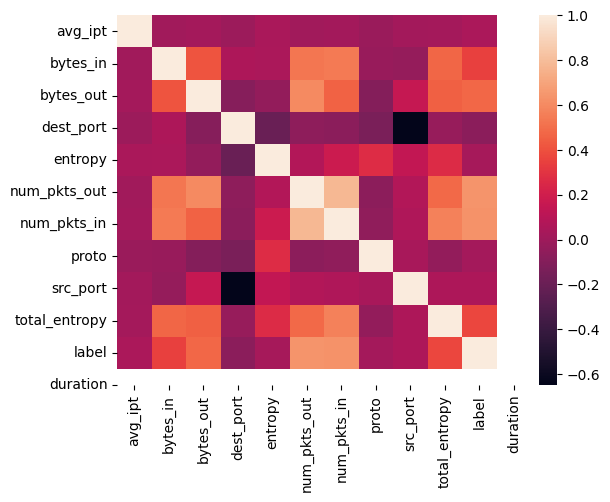

In [ ]:
import seaborn as sns

sns.heatmap(luflow2020.corr(), xticklabels=luflow2020.columns, yticklabels=luflow2020.columns)

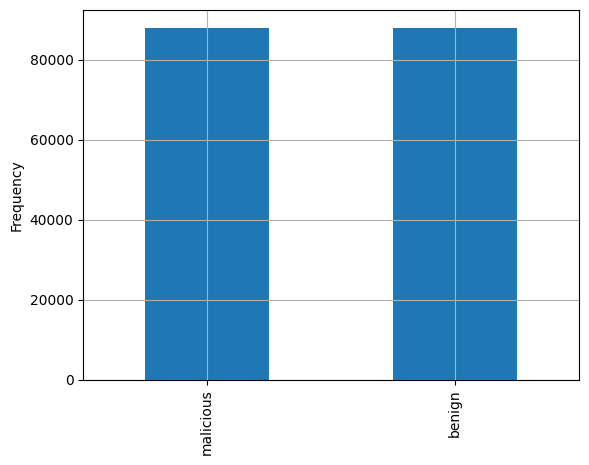

In [ ]:
# label distribution
luflow2020.label.value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.grid()
plt.show()

## Random Forest for Feature Selection

In [17]:
rfc = RandomForestClassifier()
rfc.fit(luflow_X, luflow_y)

RandomForestClassifier()

<Axes: xlabel='feature'>

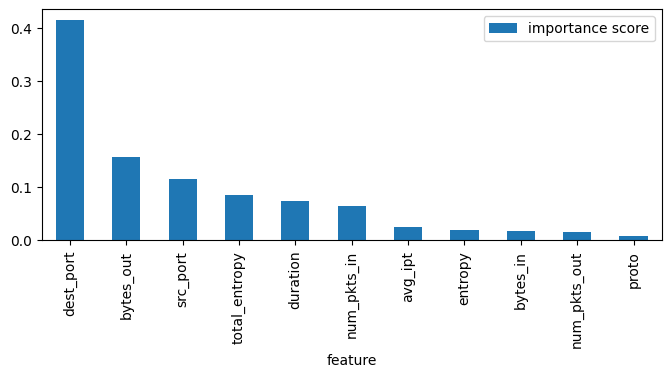

In [18]:
score = np.round(rfc.feature_importances_, 3)
feature_imp = pd.DataFrame({'feature': luflow_X.columns,'importance score': score})
feature_imp = feature_imp.sort_values('importance score', ascending=False).set_index('feature')

plt.rcParams['figure.figsize'] = (8, 3)
feature_imp.plot.bar()

In [19]:
def save_feature(features: pd.Series, dataset_name: str, algorithm: str, tag: str = ""):
    feature_count = features.shape[0]
    if not(tag == ""):
        tag = "_" + tag
    
    directory = '/content/drive/MyDrive/LUFlow/features_selected'
    file_name = f"{dataset_name}_{algorithm}_{feature_count}{tag}"
    
    # create directory to save the file
    os.makedirs(directory, exist_ok=True)
    
    features.to_csv(f"{directory}/{file_name}.csv", index=False, columns=None)

    print(f"Features are saved to {directory}/{file_name}.csv")

In [20]:
features = pd.Series(feature_imp.index[:], dtype='str')
save_feature(features=features, dataset_name='LUFlow', algorithm='RandomForestClassifier')

Features are saved to /content/drive/MyDrive/LUFlow/features_selected/LUFlow_RandomForestClassifier_11.csv


In [23]:
# define ML models without optimized hyperparameter
models = {'DT': tree.DecisionTreeClassifier(),
          'RF': RandomForestClassifier(n_jobs=-1),
          'Naive Bayes': GaussianNB(),
          'DNN': MLPClassifier(hidden_layer_sizes=(12, 12, 12), max_iter=500),
          'ANN': MLPClassifier(hidden_layer_sizes=(30), max_iter=500)}

In [25]:
luflow_train_X, luflow_test_X, luflow_train_y, luflow_test_y = train_test_split(luflow_X, luflow_y, test_size=0.3)

In [26]:
feature_set = []
scaler = StandardScaler()
scores = []

for feature in features:
    feature_set.append(feature)
    print(f"Added feature {len(feature_set)} ({feature}) ...")    
    test_X = luflow_test_X[feature_set]
    train_X = luflow_train_X[feature_set]

    train_X_scaled = scaler.fit(train_X)
    train_X_scaled = scaler.transform(train_X)
    test_X_scaled = scaler.transform(test_X)

    score_temp = [len(feature_set)]    
    for model in models:
        clf = models[model]
        clf.fit(train_X_scaled, luflow_train_y)
        prediction = clf.predict(test_X_scaled)
        accuracy = metrics.accuracy_score(luflow_test_y, prediction)
        score_temp.append(accuracy)
    scores.append(score_temp)

scores = np.array(scores)

Added feature 1 (dest_port) ...
Added feature 2 (bytes_out) ...
Added feature 3 (src_port) ...
Added feature 4 (total_entropy) ...
Added feature 5 (duration) ...
Added feature 6 (num_pkts_in) ...
Added feature 7 (avg_ipt) ...
Added feature 8 (entropy) ...
Added feature 9 (bytes_in) ...
Added feature 10 (num_pkts_out) ...
Added feature 11 (proto) ...


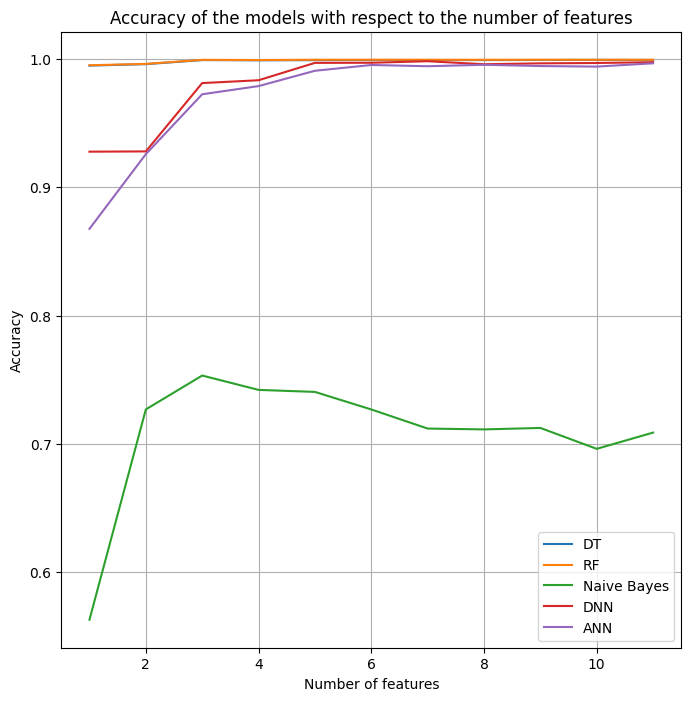

In [27]:
plt.figure(figsize=(8, 8))

for index, model in enumerate(models):
    plt.plot(scores.T[0], scores.T[index + 1], label=model)
plt.title('Accuracy of the models with respect to the number of features')
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.legend()
plt.grid()
plt.show()

In [10]:
features = pd.read_csv('/content/drive/MyDrive/LUFlow/features_selected/LUFlow_RandomForestClassifier_11.csv').squeeze()
features = features[:6]
columns_selected = features.tolist() +  ['label']

In [ ]:
columns_selected

['dest_port',
 'bytes_out',
 'src_port',
 'total_entropy',
 'num_pkts_in',
 'duration',
 'label']

In [11]:
train_X = luflow_train_X[['dest_port','bytes_out','src_port','total_entropy','num_pkts_in', 'duration']]   
test_X = luflow_test_X[['dest_port','bytes_out','src_port','total_entropy','num_pkts_in', 'duration']]

In [12]:
scale = StandardScaler()   # scaling
X_train = scale.fit_transform(train_X)
X_test = scale.transform(test_X)

## Modeling
### Decision Tree Model

In [ ]:
# generate alpha parameter value

DTmodel = tree.DecisionTreeClassifier(criterion='entropy')
path = DTmodel.cost_complexity_pruning_path(X_train, luflow_train_y)
ccp_alphas = path.ccp_alphas  
ccp_alphas = ccp_alphas[:-1]
alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    decision_tree = tree.DecisionTreeClassifier(criterion='entropy', ccp_alpha=ccp_alpha)
    scores = cross_val_score(decision_tree, train_X, luflow_train_y, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])
ideal_ccp_alpha = alpha_results.sort_values(by=['mean_accuracy'], ascending=False).iloc[0]
ideal_ccp_alpha = float(ideal_ccp_alpha['alpha'])
print(f"Decision Tree Alpha value: {ideal_ccp_alpha}")

Decision Tree Alpha value: 3.24772861979653e-05


In [ ]:
# build the decision tree model

DTmodel = tree.DecisionTreeClassifier(criterion='entropy', ccp_alpha=ideal_ccp_alpha)
DTmodel.fit(train_X, luflow_train_y)
y_pred_dt = DTmodel.predict(test_X)
accuracy = metrics.accuracy_score(luflow_test_y, prediction)
print(f"Decision Tree model Accuracy: {accuracy:.5f}")

Decision Tree model Accuracy: 0.99799


### Random Forest Model

In [ ]:
%%time
#param = [{'criterion': ['gini'], 'max_depth': [3, 5], 'min_samples_leaf': [50, 100], 'n_estimators': [10, 25]}]
#param = [{'criterion': ['gini'], 'max_depth': [1, 2], 'min_samples_leaf': [200, 500], 'n_estimators': [1, 5]}]
#param = [{'criterion': ['gini'], 'max_depth': [10, 20], 'min_samples_leaf': [5, 10], 'n_estimators': [100, 200]}]
param = [{'criterion': ['gini'], 'max_depth': [10, 20], 'min_samples_leaf': [5, 10], 'n_estimators': [100, 200],
          'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 4]}]


RFmodel = GridSearchCV(RandomForestClassifier(), param, cv=5, scoring='accuracy', n_jobs=-1, verbose=0) 
RFmodel.fit(train_X, luflow_train_y)
y_pred_RF = RFmodel.predict(test_X)

accuracy = metrics.accuracy_score(luflow_test_y, y_pred_RF)
print(f"Random Forest Model Accuracy: {accuracy:.5f}")

rf_best_params = RFmodel.best_params_
print(f"Random Forest hyperparameters: \n{rf_best_params}")

Random Forest Model Accuracy: 0.99945
Random Forest hyperparameters: 
{'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 100}
CPU times: user 23.5 s, sys: 1.41 s, total: 24.9 s
Wall time: 26min 53s


### Naive Bayes Model

In [ ]:
%%time

param = [{'var_smoothing': np.logspace(0, -9, num=100)}]

NB_model = GridSearchCV(GaussianNB(),param, cv=5,n_jobs=-1,verbose=0)
NB_model.fit(train_X, luflow_train_y)
y_pred_nb = NB_model.predict(test_X)

accuracy = metrics.accuracy_score(luflow_test_y, y_pred_nb)
print(f"Naive bayes Model Accuracy: {accuracy:.5f}")

nb_best_params = NB_model.best_params_
print(f"Optimum hyperparameters: \n{nb_best_params}")

Naive bayes Model Accuracy: 0.73672
Optimum hyperparameters: 
{'var_smoothing': 1.5199110829529332e-05}
CPU times: user 8.91 s, sys: 850 ms, total: 9.76 s
Wall time: 2min 24s


### Artificial Neural Network

In [15]:
%%time

param = [
    {'hidden_layer_sizes': [(30,), (20,), (10,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001]}
]

ann = MLPClassifier(max_iter=500)
ANNmodel = GridSearchCV(ann,param, cv=5,n_jobs=-1,verbose=0)

ANNmodel.fit(train_X, luflow_train_y)
y_pred_ann = ANNmodel.predict(test_X)

accuracy = metrics.accuracy_score(luflow_test_y, y_pred_ann)
print(f"Accuracy: {accuracy:.5f}")

ann_best_params = ANNmodel.best_params_
print(f"ANN Best hyperparameters: \n{ann_best_params}")

Accuracy: 0.95578
ANN Best hyperparameters: 
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (30,), 'solver': 'adam'}
CPU times: user 15.8 s, sys: 384 ms, total: 16.2 s
Wall time: 4min 39s


### Deep Neural Network

In [ ]:
%%time

#param = [{'hidden_layer_sizes': [(10,10, 10), (12, 12, 12), (8, 8, 8), (8, 8, 8, 8), (10, 10, 10, 10)],'activation': ['tanh', 'relu', 'logistic'],'solver': ['adam', 'sgd'],'alpha': [0.0001, 0.00001, 0.001]}]
param = [{'hidden_layer_sizes': [(10, 10), (12, 12), (8, 8), (10, 10, 10)], 
          'activation': ['tanh', 'relu', 'logistic'], 
          'solver': ['adam', 'sgd'], 
          'alpha': [0.001, 0.0001, 0.00001]}]

DNN_model = GridSearchCV(MLPClassifier(max_iter=500), param, cv=5, n_jobs=-1,verbose=0)
DNN_model.fit(train_X, luflow_train_y)
y_pred_dnn = DNN_model.predict(test_X)

accuracy = metrics.accuracy_score(luflow_test_y, y_pred_dnn)
print(f"DNN Model Accuracy: {accuracy:.5f}")

dnn_best_params = DNN_model.best_params_
print(f"DNN Best hyperparameters: \n{dnn_best_params}")

DNN Model Accuracy: 0.96853
DNN Best hyperparameters: 
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (10, 10, 10), 'solver': 'adam'}
CPU times: user 1min 7s, sys: 3.99 s, total: 1min 11s
Wall time: 1h 5min 35s
